In [1]:
import numpy as np

# Load the .npz file
data = np.load("mediapipe_landmark_embedding.npz")

# Check what’s inside
print(data.files)  # Lists all arrays stored in the file


['lmk_face_idx', 'lmk_b_coords', 'landmark_indices']


In [21]:
import numpy as np

# Load the FLAME-MediaPipe landmark mapping file
data = np.load("mediapipe_landmark_embedding.npz")

# Extract the arrays
lmk_face_idx = data["lmk_face_idx"]  # Shape: (105,)
lmk_b_coords = data["lmk_b_coords"]  # Shape: (105, 3)
landmark_indices = data["landmark_indices"]  # Shape: (105,)

# Check the contents
print("FLAME Triangle Indices:", lmk_face_idx)
# print("Barycentric Coordinates:", lmk_b_coords.shape)
print("MediaPipe Landmark Indices:", landmark_indices)


FLAME Triangle Indices: [6431 5107  391 1321 3831 1347 3845 6434    3 6592 2873  225 1802 8834
 8832 8775 3779 2874 5325 7915 5295  269 5428 6181 2212 5739 5412  338
  302 8231  307  276  274 1516 5417 5373 6647 6766 6831 6700 6656 1582
 1736 1764 6801 3729 6804 6775 1698 1626 1741 6772 6108  211 5990 3742
 2057 6110 7798 7338 2276 8803  830 3525 6277  393 5608 5555 8804 2291
 2294 7410 7371 7368 2329 7414 7415 7514 2431 2381 2384 2378 2369 2436
 2389 2311 2346 5934 1065 3426  863 8590 5974 3428  912  985  968  935
  942 6015  924  971  944 6180 8521]
MediaPipe Landmark Indices: [276 282 283 285 293 295 296 300 334 336  46  52  53  55  63  65  66  70
 105 107 249 263 362 373 374 380 381 382 384 385 386 387 388 390 398 466
   7  33 133 144 145 153 154 155 157 158 159 160 161 163 173 246 168   6
 197 195   5   4 129  98  97   2 326 327 358   0  13  14  17  37  39  40
  61  78  80  81  82  84  87  88  91  95 146 178 181 185 191 267 269 270
 291 308 310 311 312 314 317 318 321 324 375 402 

## FLAME MODEL

In [22]:
import pickle

# Load the FLAME model with correct encoding
with open('generic_model.pkl', 'rb') as f:
    flame_model = pickle.load(f, encoding='latin1')  # Use latin1 to properly handle binary data

print(len(flame_model["landmark_indices"])) 


KeyError: 'landmark_indices'

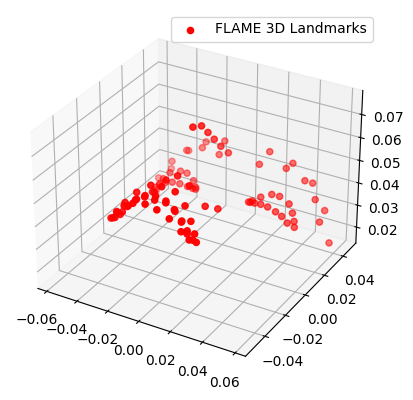

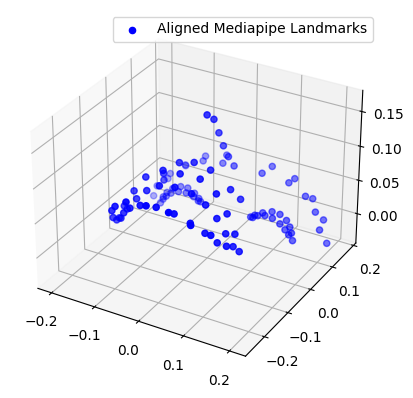

In [28]:
# ================================
# Import Required Libraries
# ================================
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

# ================================
# Step 1: Load the FLAME Model
# ================================
flame_model_path = "generic_model.pkl"  # Change this to your actual file path

# Load the FLAME model
with open(flame_model_path, "rb") as f:
    flame_model = pickle.load(f, encoding="latin1")

# Extract mean shape and faces
vertices = flame_model["v_template"]  # Mean shape vertices (N x 3)
faces = flame_model["f"]  # Face connectivity (triangles)

# ================================
# Step 2: Load FLAME Mediapipe Landmark Embedding
# ================================
landmark_embedding_path = "mediapipe_landmark_embedding.npz"  # Change this to your actual file path

# Load the landmark embedding
lmk_data = np.load(landmark_embedding_path, allow_pickle=True)

lmk_face_idx = lmk_data["lmk_face_idx"]  # Triangle indices
lmk_b_coords = lmk_data["lmk_b_coords"]  # Barycentric coordinates
landmark_indices = lmk_data["landmark_indices"]  # Mediapipe mesh indices

# ================================
# Step 3: Load Mediapipe Landmarks from CSV
# ================================
csv_file_path = "landmarks_face0_image0.csv"  # Change this to your actual file path

# Load CSV
df = pd.read_csv(csv_file_path)

# Ensure your CSV has 'X', 'Y', 'Z' columns and extract them
if {"X", "Y", "Z"}.issubset(df.columns):
    mediapipe_landmarks = df[["X", "Y", "Z"]].values  # Extract XYZ as NumPy array
else:
    raise ValueError("CSV file must contain 'X', 'Y', and 'Z' columns!")

# ================================
# Step 4: Compute FLAME 3D Landmarks
# ================================
def get_flame_landmarks(flame_vertices, faces, lmk_face_idx, lmk_b_coords):
    """
    Compute 3D landmark positions on FLAME mesh using barycentric interpolation.
    """
    lmk_3d = np.zeros((lmk_face_idx.shape[0], 3))  # Output landmarks

    for i, face_id in enumerate(lmk_face_idx):
        # Get the three triangle vertices in FLAME
        triangle = faces[face_id]
        v1, v2, v3 = flame_vertices[triangle]

        # Compute landmark position using barycentric coordinates
        lmk_3d[i] = (
            lmk_b_coords[i, 0] * v1 +
            lmk_b_coords[i, 1] * v2 +
            lmk_b_coords[i, 2] * v3
        )

    return lmk_3d

# Compute FLAME landmarks
flame_landmarks_3d = get_flame_landmarks(vertices, faces, lmk_face_idx, lmk_b_coords)

# ================================
# Step 5: Align Mediapipe Landmarks to FLAME
# ================================
def align_mediapipe_to_flame(mediapipe_landmarks, flame_landmarks):
    """
    Aligns Mediapipe landmarks to FLAME landmarks using Procrustes analysis.
    """
    # Compute centroids
    mp_centroid = np.mean(mediapipe_landmarks, axis=0)
    flame_centroid = np.mean(flame_landmarks, axis=0)

    # Center the points
    mp_centered = mediapipe_landmarks - mp_centroid
    flame_centered = flame_landmarks - flame_centroid

    # Compute optimal rotation using SVD
    U, _, Vt = np.linalg.svd(mp_centered.T @ flame_centered)
    R_opt = U @ Vt  # Optimal rotation matrix

    # Ensure a proper rotation (avoid reflection)
    if np.linalg.det(R_opt) < 0:
        Vt[-1, :] *= -1
        R_opt = U @ Vt

    # Apply transformation
    aligned_mediapipe = (mp_centered @ R_opt) + flame_centroid
    return aligned_mediapipe

# Align the Mediapipe landmarks
aligned_mediapipe_landmarks = align_mediapipe_to_flame(mediapipe_landmarks, flame_landmarks_3d)

# ================================
# Step 6: Visualize the Results
# ================================
def plot_3d(points, color="blue", label=""):
    """
    Plot 3D points using Matplotlib.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=color, label=label)
    ax.legend()
    plt.show()

# Plot FLAME landmarks
plot_3d(flame_landmarks_3d, "red", "FLAME 3D Landmarks")

# Plot aligned Mediapipe landmarks
plot_3d(aligned_mediapipe_landmarks, "blue", "Aligned Mediapipe Landmarks")


<Figure size 1500x500 with 0 Axes>

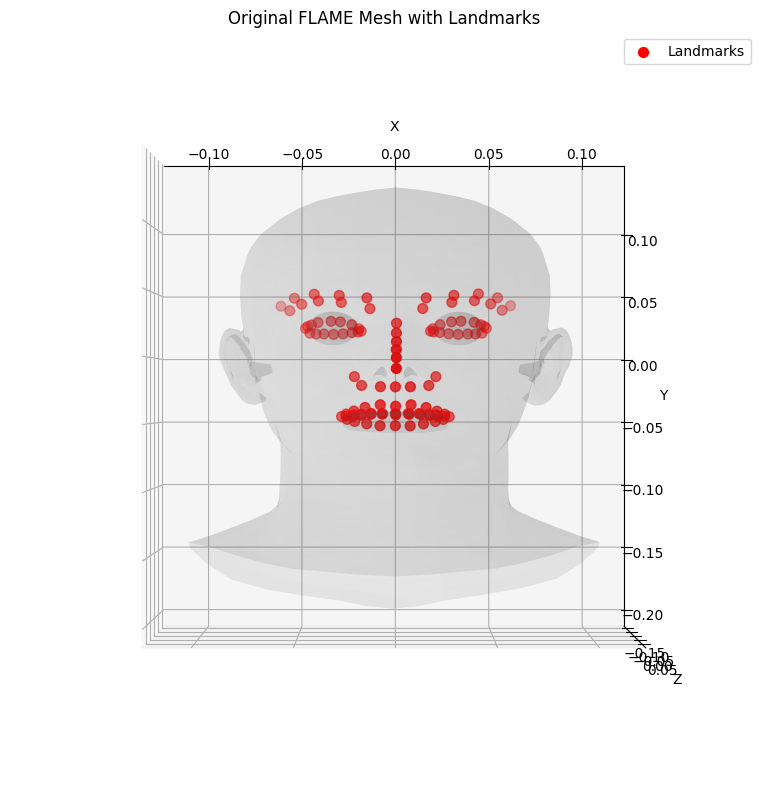

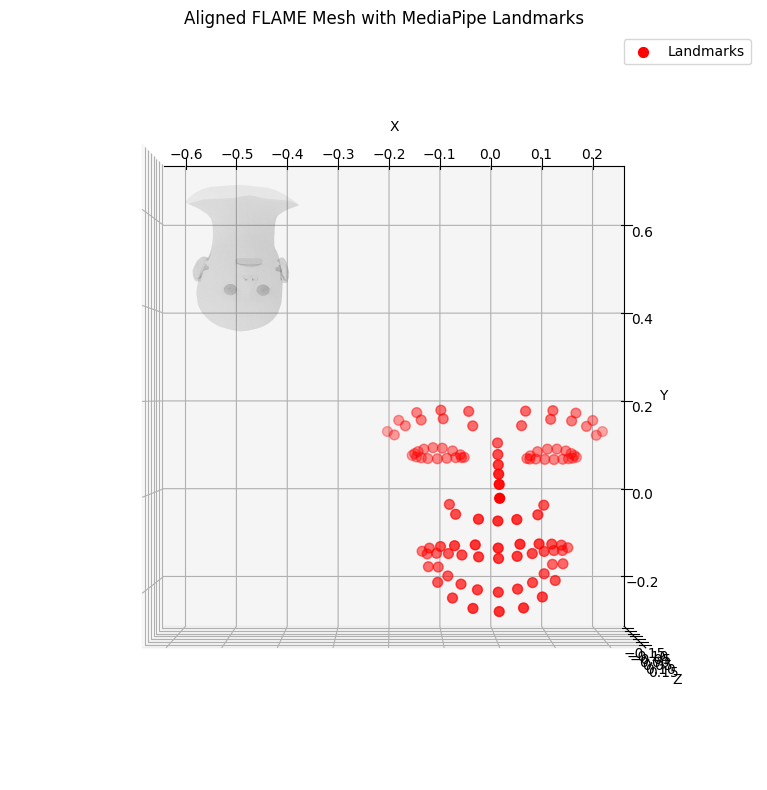

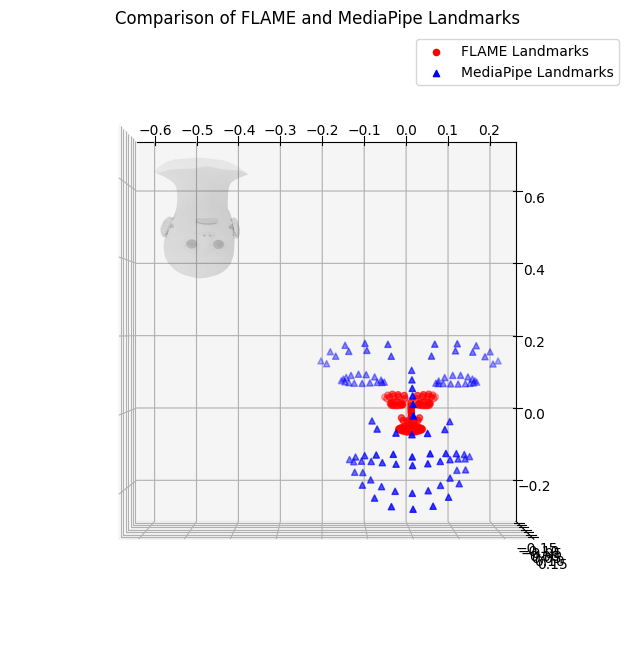

In [32]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

# ================================
# Step 1: Load the FLAME Model
# ================================
flame_model_path = "generic_model.pkl"

with open(flame_model_path, "rb") as f:
    flame_model = pickle.load(f, encoding="latin1")

vertices = flame_model["v_template"]
faces = flame_model["f"]

# ================================
# Step 2: Load FLAME Mediapipe Landmark Embedding
# ================================
landmark_embedding_path = "mediapipe_landmark_embedding.npz"
lmk_data = np.load(landmark_embedding_path, allow_pickle=True)

lmk_face_idx = lmk_data["lmk_face_idx"]
lmk_b_coords = lmk_data["lmk_b_coords"]
landmark_indices = lmk_data["landmark_indices"]

# ================================
# Step 3: Load Mediapipe Landmarks from CSV
# ================================
csv_file_path = "landmarks_face0_image0.csv"
df = pd.read_csv(csv_file_path)

# Extract landmarks depending on your CSV format
if {"x", "y", "z"}.issubset(df.columns):
    mediapipe_landmarks = df[["x", "y", "z"]].values
elif {"X", "Y", "Z"}.issubset(df.columns):
    mediapipe_landmarks = df[["X", "Y", "Z"]].values
else:
    raise ValueError("CSV file must contain either 'x,y,z' or 'X,Y,Z' columns!")

# ================================
# Step 4: Compute FLAME 3D Landmarks
# ================================
def get_flame_landmarks(flame_vertices, faces, lmk_face_idx, lmk_b_coords):
    lmk_3d = np.zeros((lmk_face_idx.shape[0], 3))
    
    for i, face_id in enumerate(lmk_face_idx):
        triangle = faces[face_id]
        v1, v2, v3 = flame_vertices[triangle]
        lmk_3d[i] = (
            lmk_b_coords[i, 0] * v1 +
            lmk_b_coords[i, 1] * v2 +
            lmk_b_coords[i, 2] * v3
        )
    
    return lmk_3d

flame_landmarks_3d = get_flame_landmarks(vertices, faces, lmk_face_idx, lmk_b_coords)

# ================================
# Step 5: Align Mediapipe Landmarks to FLAME
# ================================
def align_mediapipe_to_flame(mediapipe_landmarks, flame_landmarks):
    mp_centroid = np.mean(mediapipe_landmarks, axis=0)
    flame_centroid = np.mean(flame_landmarks, axis=0)
    
    mp_centered = mediapipe_landmarks - mp_centroid
    flame_centered = flame_landmarks - flame_centroid
    
    U, _, Vt = np.linalg.svd(mp_centered.T @ flame_centered)
    R_opt = U @ Vt
    
    if np.linalg.det(R_opt) < 0:
        Vt[-1, :] *= -1
        R_opt = U @ Vt
    
    aligned_mediapipe = (mp_centered @ R_opt) + flame_centroid
    return aligned_mediapipe, R_opt, flame_centroid - (mp_centroid @ R_opt)

aligned_mediapipe_landmarks, R_opt, t_opt = align_mediapipe_to_flame(mediapipe_landmarks, flame_landmarks_3d)

# Transform all vertices using the same alignment
aligned_vertices = (vertices - np.mean(mediapipe_landmarks, axis=0)) @ R_opt + np.mean(flame_landmarks_3d, axis=0)

# ================================
# Step 6: Enhanced Visualization
# ================================
def plot_3d_mesh_with_landmarks(vertices, faces, landmarks, title="", alpha=0.1):
    """
    Plot the FLAME mesh and landmarks in 3D
    """
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the mesh
    mesh = ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2],
                          triangles=faces,
                          alpha=alpha,
                          color='gray')
    
    # Plot the landmarks
    ax.scatter(landmarks[:, 0], landmarks[:, 1], landmarks[:, 2],
              c='red',
              marker='o',
              s=50,
              label='Landmarks')
    
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    
    # Add legend
    ax.legend()
    
    # Adjust the view
    ax.view_init(elev=90., azim=-90)
    
    plt.tight_layout()
    return fig, ax

# Create visualization plots
plt.figure(figsize=(15, 5))

# Plot 1: Original FLAME mesh with original landmarks
fig1, ax1 = plot_3d_mesh_with_landmarks(
    vertices, faces, flame_landmarks_3d,
    title="Original FLAME Mesh with Landmarks"
)
plt.show()

# Plot 2: Aligned mesh with MediaPipe landmarks
fig2, ax2 = plot_3d_mesh_with_landmarks(
    aligned_vertices, faces, aligned_mediapipe_landmarks,
    title="Aligned FLAME Mesh with MediaPipe Landmarks"
)
plt.show()

# Plot 3: Comparison view (both sets of landmarks)
fig3 = plt.figure(figsize=(12, 8))
ax3 = fig3.add_subplot(111, projection='3d')

# Plot the aligned mesh
mesh = ax3.plot_trisurf(aligned_vertices[:, 0], 
                       aligned_vertices[:, 1], 
                       aligned_vertices[:, 2],
                       triangles=faces,
                       alpha=0.1,
                       color='gray')

# Plot both sets of landmarks
ax3.scatter(flame_landmarks_3d[:, 0], 
           flame_landmarks_3d[:, 1], 
           flame_landmarks_3d[:, 2],
           c='red',
           marker='o',
           label='FLAME Landmarks')

ax3.scatter(aligned_mediapipe_landmarks[:, 0], 
           aligned_mediapipe_landmarks[:, 1], 
           aligned_mediapipe_landmarks[:, 2],
           c='blue',
           marker='^',
           label='MediaPipe Landmarks')

ax3.set_title("Comparison of FLAME and MediaPipe Landmarks")
ax3.legend()
ax3.view_init(elev=90., azim=-90)
plt.show()

# Save the visualizations
fig1.savefig('original_flame_mesh.png')
fig2.savefig('aligned_flame_mesh.png')
fig3.savefig('landmark_comparison.png')